In [10]:
# Configuración del entorno (compatible con Colab y local)
import os
import sys
from pathlib import Path

# Detectar si estamos en Google Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')   
    # Si estamos en Colab, clonar el repositorio
    !git clone https://github.com/ninja-marduk/ml_precipitation_prediction.git
    %cd ml_precipitation_prediction
    # Instalar dependencias necesarias
    !pip install -r requirements.txt
    !pip install xarray netCDF4 optuna matplotlib seaborn lightgbm xgboost scikit-learn
    BASE_PATH = '/content/drive/MyDrive/ml_precipitation_prediction'
else:
    # Si estamos en local, usar la ruta actual
    if '/notebooks' in os.getcwd():
        BASE_PATH = Path('..')
    else:
        BASE_PATH = Path('.')

print(f"Entorno configurado. Usando ruta base: {BASE_PATH}")

# Si BASE_PATH viene como string, lo convertimos
BASE_PATH = Path(BASE_PATH)

# Ahora puedes concatenar correctamente
model_output_dir = BASE_PATH / 'models' / 'output'
model_output_dir.mkdir(parents=True, exist_ok=True)

data_file = BASE_PATH / 'data' / 'output' / 'complete_dataset_with_features.nc'
print(f"Buscando archivo en: {data_file}")

Entorno configurado. Usando ruta base: ..
Buscando archivo en: ../data/output/complete_dataset_with_features.nc


ℹ️ No se detectó GPU, usando CPU


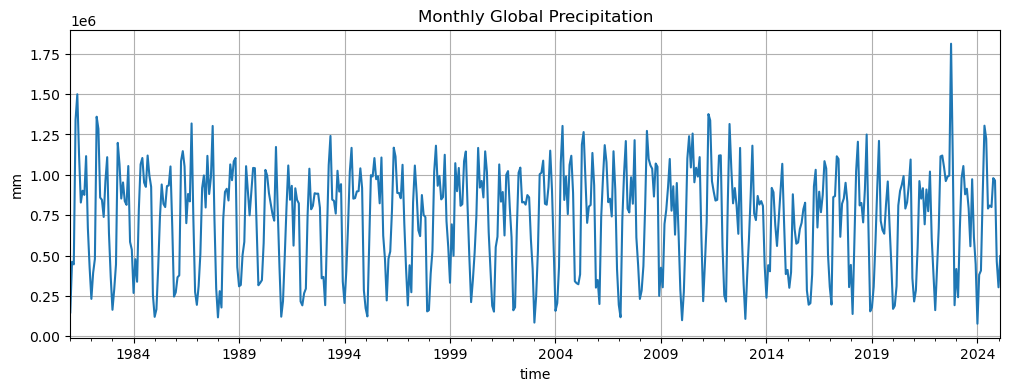

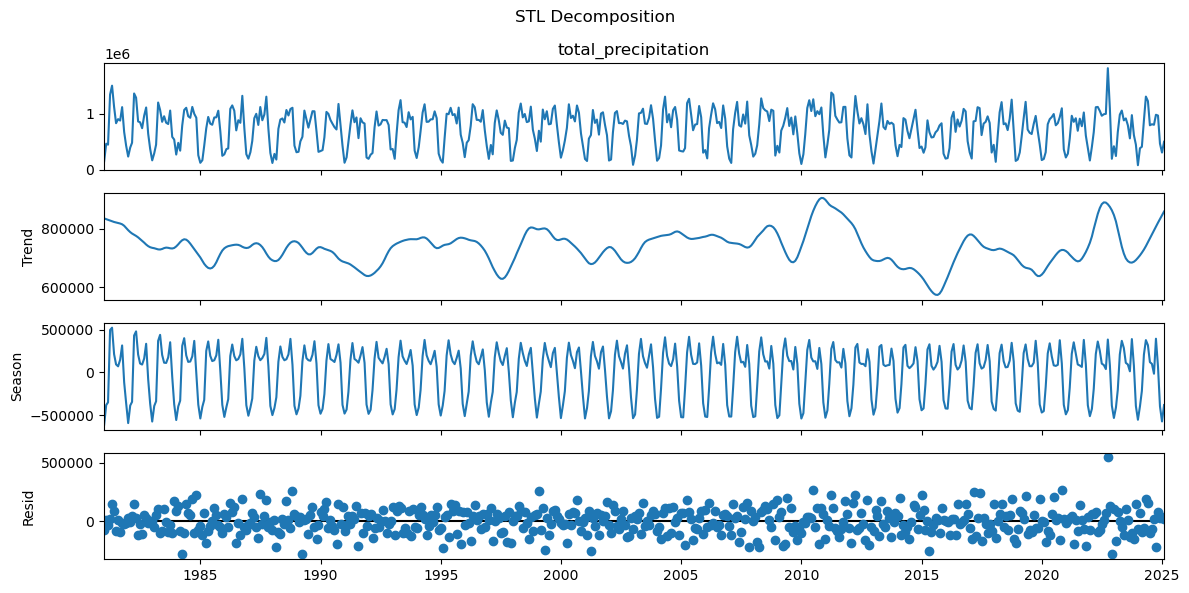

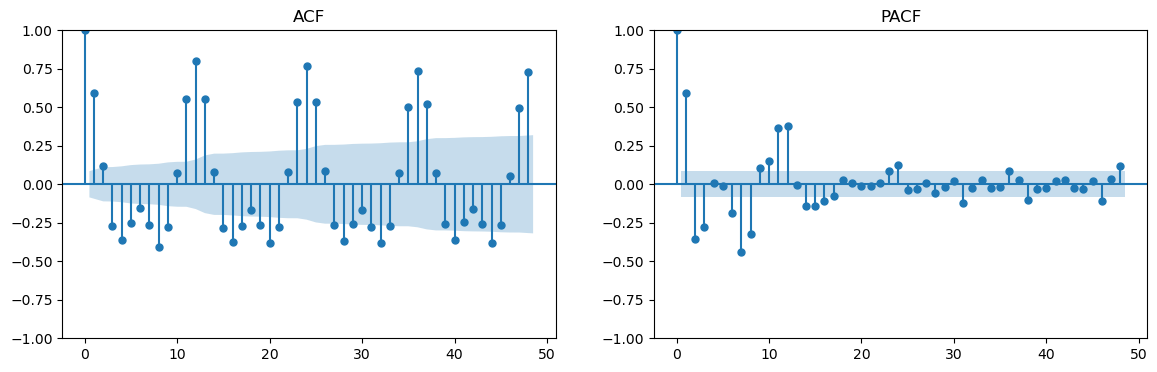

In [11]:
# GPU‐aware + RAM‐optimized pipeline con saneamiento de datos

import os
import warnings

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error
)

import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    ConvLSTM2D,
    MaxPooling2D,
    BatchNormalization,
    Dropout,
    Flatten,
    Dense
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

warnings.filterwarnings("ignore")

# 1) Configurar GPU y mixed precision (opcionales)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
    device = '/GPU:0'
    print("✅ GPU habilitada, memory_growth ON")
else:
    device = '/CPU:0'
    print("ℹ️ No se detectó GPU, usando CPU")

# Forzamos float32 para evitar problemas de dtype
mixed_precision.set_global_policy('float32')

# 2) Rutas y carga de datos
DATA_PATH  = data_file
MODEL_PATH = model_output_dir
os.makedirs(MODEL_PATH, exist_ok=True)

# Carga de la serie
ds     = xr.open_dataset(DATA_PATH)
precip = ds['total_precipitation'].sum(dim=['latitude','longitude']).to_series()

# 3) Visualización rápida
plt.figure(figsize=(12,4))
precip.plot(title='Monthly Global Precipitation')
plt.ylabel('mm'); plt.grid(); plt.show()

# 4) STL + ACF/PACF
res = STL(precip, seasonal=13).fit()
fig = res.plot(); fig.set_size_inches(12,6)
plt.suptitle('STL Decomposition'); plt.tight_layout(); plt.show()

fig, axes = plt.subplots(1,2,figsize=(14,4))
plot_acf(precip, lags=48, ax=axes[0]); axes[0].set_title('ACF')
plot_pacf(precip, lags=48, ax=axes[1]); axes[1].set_title('PACF')
plt.show()

## Conclusiones y recomendaciones de ventana de entrenamiento

A partir del análisis de la serie temporal y las funciones ACF/PACF, se extraen las siguientes conclusiones y pautas para diseñar la ventana de entrada de un modelo que prediga 12 meses por delante:

### 1. Comportamiento de la serie

- **Tendencia**  
  Ligera caída hasta mediados de los 90 ’s, posterior estabilización y repunte en los últimos años.

- **Estacionalidad**  
  Ciclo anual muy marcado, con amplitud aproximada de ± 400 000 mm.

- **Residuo**  
  Ruido estacionario con variaciones dentro de ± 100 000 mm.

### 2. Dependencias temporales (ACF / PACF)

| Lag  | ACF     | PACF    |
|------|---------|---------|
| 1    | ~ 0.80  | corte   |
| 2–4  | moderado descenso ↘︎  | valores residuales insignificantes |
| 12   | ~ 0.75  | refuerzo ~ 0.35 |
| 24, 36 | ≈ 0.50–0.70 | débiles  |

### 3. Recomendaciones de ventana de entrada

Para capturar tanto la **dependencia inmediata** como la **estacionalidad anual**, se recomienda una ventana deslizante que incluya:

1. **Lags cortos** (dependencia inmediata):  
   – Meses 1–4 anteriores  
2. **Lags estacionales** (dependencia anual):  
   – Meses 12, 24 y 36 anteriores  

Además, para predecir eficientemente **12 meses por delante**, es aconsejable usar al menos **36–48 meses** de historia como entrada:

```python
window_size = 36  # ó 48 para mayor contexto
features = [
    series.shift(1), series.shift(2), series.shift(3), series.shift(4),
    series.shift(12), series.shift(24), series.shift(36)
]


In [12]:
import os
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Dropout, Flatten, Dense,
    ConvLSTM2D, BatchNormalization, Conv2D
)
from tensorflow.keras.callbacks import EarlyStopping

# ─── CONFIGURACIÓN GENERAL ─────────────────────────────────────────────────────
warnings.filterwarnings('ignore')
mixed_precision.set_global_policy('float32')

# GPU / CPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
    DEVICE = '/GPU:0'
else:
    DEVICE = '/CPU:0'

# Rutas base (ajusta según tu proyecto)
DATA_DIR  = BASE_PATH / 'data' / 'output'

# Lista de archivos a procesar
FILES = [
    "complete_dataset_with_features.nc",
    "complete_dataset_with_features_with_clusters_elevation.nc"
]

# Parámetros comunes
WINDOW    = 48        # tamaño de ventana para series univariadas
TEST_SIZE = 0.2       # 20% validación
EPOCHS    = 50        # épocas por defecto para ConvLSTM2D
BATCH     = 16        # batch size por defecto

# ─── FUNCIONES AUXILIARES ───────────────────────────────────────────────────────
def create_supervised_1d(series, window):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series.iloc[i-window:i].values)
        y.append(series.iloc[i])
    return np.array(X), np.array(y)

def scale_split(X, y, test_size=TEST_SIZE):
    n = len(X)
    split = int(n * (1 - test_size))
    sx = StandardScaler().fit(X.reshape(-1, 1))
    sy = StandardScaler().fit(y.reshape(-1, 1))
    Xs = sx.transform(X.reshape(-1, 1)).reshape(X.shape)
    ys = sy.transform(y.reshape(-1, 1)).reshape(-1)
    return Xs[:split], Xs[split:], ys[:split], ys[split:], sx, sy

def plot_keras_curves(history, name):
    for metric in ('loss', 'mae', 'mape'):
        if metric in history.history:
            plt.figure(figsize=(6,2.5))
            plt.plot(history.history[metric], label='train')
            plt.plot(history.history[f'val_{metric}'], label='val')
            plt.title(f'{name} {metric.upper()}')
            plt.xlabel('Epoch')
            plt.legend()
            plt.tight_layout()
            plt.show()

# ─── BUCLE PRINCIPAL SOBRE AMBOS DATASETS ──────────────────────────────────────
for fname in FILES:
    print(f"\n\n===== Procesando {fname} =====")
    path = DATA_DIR / fname
    ds   = xr.open_dataset(path)

    # Serie global agregada
    ts_global = ds['total_precipitation'].sum(dim=['latitude','longitude']).to_series()

    # ─── BLOQUE 1: Univariado por celda (RF, XGB, LGBM) ─────────────────────────
    print(">> Bloque 1: modelos univariados por celda…")
    models_1d = {
        'RF':  RandomForestRegressor(random_state=0),
        'XGB': XGBRegressor(use_label_encoder=False, eval_metric='rmse'),
        'LGB': LGBMRegressor()
    }
    results_cells = []

    for lat in ds.latitude.values:
        for lon in ds.longitude.values:
            ts_cell = ds['total_precipitation'].sel(latitude=lat, longitude=lon).to_series()
            if ts_cell.isnull().any():
                continue

            X1d, y1d = create_supervised_1d(ts_cell, WINDOW)
            Xtr1d, Xv1d, ytr1d, yv1d, _, _ = scale_split(X1d, y1d)

            for name, mdl in models_1d.items():
                mdl.fit(Xtr1d, ytr1d)
                ypred = mdl.predict(Xv1d)
                rmse = np.sqrt(mean_squared_error(yv1d, ypred))
                r2   = r2_score(yv1d, ypred)
                results_cells.append({
                    'dataset': fname,
                    'model':   name,
                    'lat':     float(lat),
                    'lon':     float(lon),
                    'rmse':    rmse,
                    'r2':      r2
                })

    df_cells = pd.DataFrame(results_cells)
    summary_cells = df_cells.groupby('model')[['rmse','r2']].mean()
    print("Univariado por celda — RMSE y R² medios:")
    print(summary_cells)

    # ─── BLOQUE 2: Espaciotemporal many‐to‐one con ConvLSTM2D ───────────────────
    print(">> Bloque 2: ConvLSTM2D espaciotemporal…")
    H, W = len(ds.latitude), len(ds.longitude)
    XX, YY = [], []

    times = ds.time.values
    for i in range(WINDOW, len(times)):
        past = ds['total_precipitation'].isel(time=slice(i-WINDOW, i))
        XX.append(past.values[..., None])     # (WINDOW,H,W,1)
        YY.append(ds['total_precipitation'].isel(time=i).values[..., None])  # (H,W,1)

    XX = np.stack(XX)
    YY = np.stack(YY)
    N  = len(XX)
    split = int((1-TEST_SIZE)*N)
    Xtr_st, Xv_st = XX[:split], XX[split:]
    ytr_st, yv_st = YY[:split], YY[split:]

    def build_convlstm_2d(window, h, w, lr=1e-3, drop=0.2):
        m = Sequential([
            Input((window, h, w, 1)),
            ConvLSTM2D(32, (3,3), padding='same', return_sequences=False),
            BatchNormalization(), Dropout(drop),
            Conv2D(1, (1,1), activation='linear', padding='same')
        ])
        m.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss='mse', metrics=['mae'])
        return m

    with tf.device(DEVICE):
        model_st = build_convlstm_2d(WINDOW, H, W)
        history = model_st.fit(
            Xtr_st, ytr_st,
            validation_data=(Xv_st, yv_st),
            epochs=EPOCHS, batch_size=BATCH,
            callbacks=[EarlyStopping('val_loss', patience=5, restore_best_weights=True)],
            verbose=1
        )

    ypred_st = model_st.predict(Xv_st)
    rmse_st  = np.sqrt(mean_squared_error(yv_st.ravel(), ypred_st.ravel()))
    r2_st    = r2_score(yv_st.ravel(), ypred_st.ravel())
    print(f"ConvLSTM2D → RMSE: {rmse_st:.2f} mm, R²: {r2_st:.3f}")
    plot_keras_curves(history, f"ConvLSTM2D ({fname})")

print("\n✓ Procesamiento completado para todos los datasets.")




===== Procesando complete_dataset_with_features.nc =====
>> Bloque 1: modelos univariados por celda…
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6204
[LightGBM] [Info] Number of data points in the train set: 385, number of used features: 48
[LightGBM] [Info] Start training from score -0.029373
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

KeyboardInterrupt: 

### 4. Decisión final

Se recomienda implementar un modelo que utilice una ventana de entrada de **48 meses** con las **7 features** seleccionadas (lags 1–4, 12, 24, 36). Esto permitirá capturar tanto las dependencias inmediatas como las estacionales, optimizando la predicción de **12 meses por delante**. Se hacen las modificaciones en el script _data/transformation/update/dataset_update.py_ de este repositorio.

Teniendo en cuenta los modelos específicos las ventanas de entrada pueden variar de 60 hasta 80 meses, por lo que se recomienda ajustar la ventana de entrada según el modelo a utilizar.